# Authorship Verification

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

## Loading

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text if l.text else "" for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text if p.text else "" for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            lemma = lemma or ""  # Ensure lemma is not None
            pos = pos or ""      # Ensure pos is not None
            
            for l, p in zip(lemma.split('+'), pos.split('+')):
                if p == 'NOU-P':
                    verse.append(('NOU-P', 'NOU-P'))
                else:
                    verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

id  \
80   grimbergse_oorlog_cont                               
217  spiegel_der_sonden_fragm_ge1                         
11   bediedenisse_van_der_missen                          
104  roman_van_lancelot_fragm_br                          
126  madelgijs_fragm_d                                    
45   Der naturen bloeme, handschrift D                    
145  noch_van_salladine                                   
99   roman_van_jonathas_ende_rosafiere_fragm_a            
40   cyromanchie_van_den_pape_van_den_hamme_chiromantie   
154  ongeidentificeerd_4                                  

                                      title              author provenance  \
80   Grimbergse oorlog (cont)                NaN                 cdrom-mnl   
217  Spiegel der sonden                      NaN                 cdrom-mnl   
11   Bediedenisse van der missen             NaN                 cdrom-mnl   
104  Lancelot                                NaN                 cdrom-mnl   
126  Madelgijs                               NaN                 cdrom-mnl   
45   Der naturen bloeme                      Jacob van Maerlant  CG1         
145  Noch van Salladine                      NaN                 cdrom-mnl   
99   Jonathas ende Rosafiere                 NaN                 cdrom-mnl   
40   Cyromanchie van den pape van den Hamme  NaN                 cdrom-mnl   
154  Ongeïdentificeerd (4)                   NaN                 cdrom-mnl   

    date_range  genre        subgenre exclude  
80   1300-1350  Epiek  Historiografie  NaN     
217  1300-1400  Epiek  Didactiek       NaN     
11   1340-1360  Epiek  Religie         NaN     
104  1300-1350  Epiek  Arthur          NaN     
126  1340-1360  Epiek  Karel           NaN     
45   1287-1287  Epiek  Didactiek       NaN     
145  1390-1410  Epiek  Ridder          NaN     
99   1500-1520  Epiek  Ridder          NaN     
40   1440-1460  Epiek  Didactiek       NaN     
154  1300-1400  Epiek  Karel           NaN

In [4]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml_galahad_BY-split/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 164/164 [00:09<00:00


## Segmentation 

In [5]:
len(work_df[work_df['title'].str.contains('Eduwaert')]['text'].iloc[0])

2018

In [6]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1989) # segment length zodat Korte kroniek er nog bij kan
segment_df.sample(5)

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1311.03it/s]


title              author  genre        subgenre  \
47   Der leken spieghel          Jan van Boendale    Epiek  Didactiek        
266  Spiegel historiael (P1-P4)  Jacob van Maerlant  Epiek  Historiografie   
5    Alexanders geesten          Jacob van Maerlant  Epiek  Ridder           
270  Spiegel historiael (P1-P4)  Jacob van Maerlant  Epiek  Historiografie   
208  Roman der Lorreinen II      NaN                 Epiek  Karel            

     segment-idx  \
47   5             
266  33            
5    6             
270  37            
208  2             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     text  
47   [pijn, toegespreken, toen, gezond, kunnen, dood, groot, vernemen, samen, kind, winnen, geschieden, niet, gaan, doen, vader, gader, aldus, NOU-P, verbieden, lieden, kunnen, aan, woord, voort, gij, ik, dag, klaag, ontzind, ongemind, land, tehand, voort, hoeren, zoon, troon, deren, begeren, al, geschal, meer, zeer, gebaren, vaart, lachen, zien, kind, twint, zin, innen, NOU-P, daar, lezen, NOU-P, zeggen, wijsheid, sake, tongemak, gaan, bestaan, woerd, hoeren, keren, leren, wijsheid, mede, kind, minnen, statuut, uiten, leer, eer, zin, min, kastijden, gedijen, vroed, doen, dan, man, deugen, mogen, iet, niet, ongelet, wet, waar, daar, gelijk, aardrijk, voren, horen, algader, vader, vinden, twint, dat, zijn, gelijke, ...]                                                                   
266  [geweld, veld, strijd, zijde, zege, allerwegen, heer, eer, bede, stede, weer, heer, groot, noot, weer, heer, heten, bezien, komen, nemen, kracht, vechten, trouw, vrouw, haar, schaar, noen, koen, dood, groot, schaar, zijn, aan, man, verheffen, leven, heer, meer, gebuur, avontuur, mogendheid, aanbeden, gebod, NOU-P, haar, keur, goud, willen, deur, figuur, schoon, troon, hemelrijk, subtiellijk, daar, openbaar, mede, doen, hij, NOU-P, roven, geloven, gezel, tellen, onzegen, allerwegen, echt, gevecht, Romein, plein, dunouw, schouw, vlieten, heten, persie, bij, twee, een, heer, keren, eenwijg, prijg, geven, hoeven, weren, heer, samen, nemen, ongenade, bidden, zeer, eer, dood, wederstoot, zaan, onderdaan, kind, NOU-P, rijk, vromelijk, ...]                                                
5    [hebben, kleven, tijl, gijl, vallen, al, lang, bedwang, dag, zien, land, hand, gewoud, koud, wijd, tijd, zee, mee, beschrijven, beneven, properheid, sierheid, gereed, weten, NOU-P, daarna, regen, daarjegen, rijk, NOU-P, daar, daarnaar, aarderijk, hovaardelijk, viseren, versieren, ook, wierook, NOU-P, aardrijk, NOU-P, bartanie, som, komen, noorman, kunnen, Lombard, zwoerd, prijs, wijs, graf, heffen, loon, kroon, mede, stad, zoon, gene, genendelijk, koninkrijk, waan, gestaan, dragen, genoeg, jaar, waar, gestaan, ontvangen, schrijven, drijven, weten, gereed, soudenier, manier, goud, menigvout, plegen, dagen, schaar, zijn, liggen, plegen, heer, geren, waart, vaart, al, geschal, zijn, nieuwmare, schier, soudenier, baron, koen, zullen, willen, verdrijven, leven, blijven, katijf, ...]  
270  [blinde, heten, verdriet, zitten, stad, heer, nimmermeer, dag, geliggen, weder, nijden, samen, naam, dood, groot, zoon, kroon, ontzetten, wet, kroon, troon, dragen, gevoeg, naar, jaar, deze, wezen, NOU-P, na, daarnaar, jaar, dood, groot, jaar, naa

In [7]:
len(segment_df[segment_df['title'].str.contains('duwaert')]['text'].iloc[0])

1989

## Combinations

In [8]:
calib_df = segment_df[
    (segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem'})) | 
    (segment_df['title'].isin({'Jans teesteye'}))
]

trg_df = segment_df[segment_df['title'].isin({#'Brabantsche yeesten (B1-3)', 
                                              #'Brabantsche yeesten (B4-5)',
                                              'Brabantsche yeesten (B5)',
                                              'Korte kroniek van Brabant (korte versie 1)',
                                              'Korte kroniek van Brabant (lange versie)',
                                              'Der leken spieghel',
                                              'Jans teesteye',
                                              'Van den derden Eduwaert',
                                              'Melibeus',
                                              'Boec Exemplaer',
                                              'Dietsche doctrinale',
                                              'Boec vander wraken'
                                             })]
                                              # 
                                              
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']

#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [9]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         44
                      Historie van Troyen                20
                      Rijmbijbel                         18
Lodewijk van Velthem  Spiegel historiael (P5)            13
                      Merlijn-continuatie                12
Jacob van Maerlant    Der naturen bloeme                 8 
                      Alexanders geesten                 7 
                      Sinte Franciscus leven             5 
Lodewijk van Velthem  Spiegel historiael (P4)            3 
Jan van Boendale      Jans teesteye                      2 
Jacob van Maerlant    Heymelijchede der heymelijcheit    1 
Name: count, dtype: int64

In [10]:
trg_df[['title']].value_counts()

title                                   
Der leken spieghel                          11
Dietsche doctrinale                         3 
Boec vander wraken                          2 
Brabantsche yeesten (B5)                    2 
Jans teesteye                               2 
Korte kroniek van Brabant (lange versie)    1 
Melibeus                                    1 
Van den derden Eduwaert                     1 
Name: count, dtype: int64

In [11]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
D    31
S    24
Name: count, dtype: int64


title1                   title2 authorship
51  Jans teesteye       Spiegel historiael (P5)  D        
12  Der naturen bloeme  Rijmbijbel               S        
9   Alexanders geesten  Spiegel historiael (P5)  D        
34  Rijmbijbel          Sinte Franciscus leven   S        
18  Der naturen bloeme  Spiegel historiael (P5)  D

In [74]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'NOU-P' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'NOU-P' not in text[i]:
            yield text[i]

params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()
X.shape

(133, 10000)

In [13]:
# Sanity check to make sure all proper nouns are ignored and not present in the vector (important for Korte Kroniek)

# get the features from the vectorizer
feature_names = vectorizer.get_feature_names_out()
contains_nou_p = any("NOU-P" in feature for feature in feature_names)

# result
print("Does the feature list contain 'NOU-P'?", contains_nou_p)

Does the feature list contain 'NOU-P'? False


In [14]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

title1                   title2 authorship  distance
0     Alexanders geesten       Der naturen bloeme       S          0.944835
1     Alexanders geesten       Der naturen bloeme       S          0.895134
2     Alexanders geesten       Der naturen bloeme       S          0.914813
3     Alexanders geesten       Der naturen bloeme       S          0.898831
4     Alexanders geesten       Der naturen bloeme       S          0.895495
...                  ...                      ...      ..               ...
7277  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.726237
7278  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.716211
7279  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.669874
7280  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.709472
7281  Spiegel historiael (P4)  Spiegel historiael (P5)  S          0.710049

[7282 rows x 4 columns]

max(f1)=0.0 @ theta=0.1132


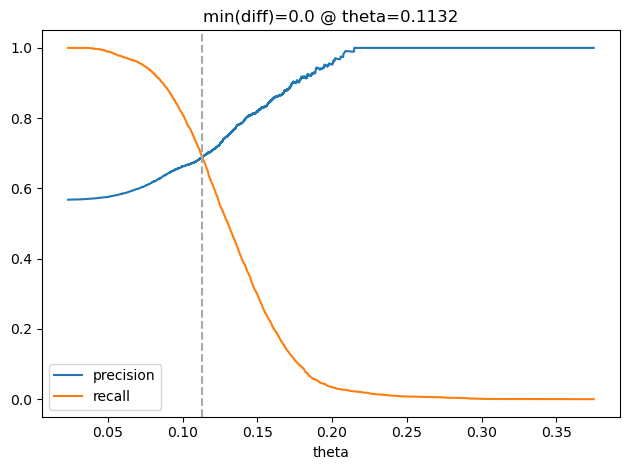

In [15]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [16]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.8867945967933448

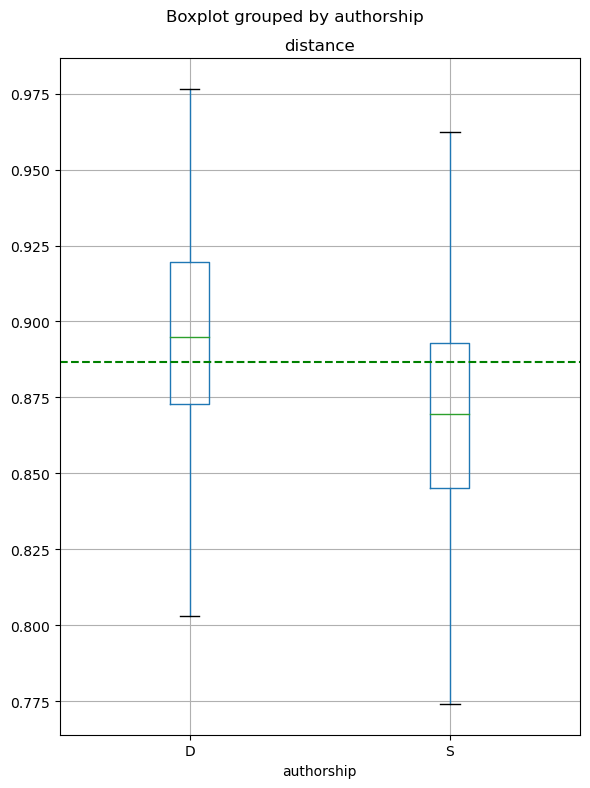

In [17]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

##### Target

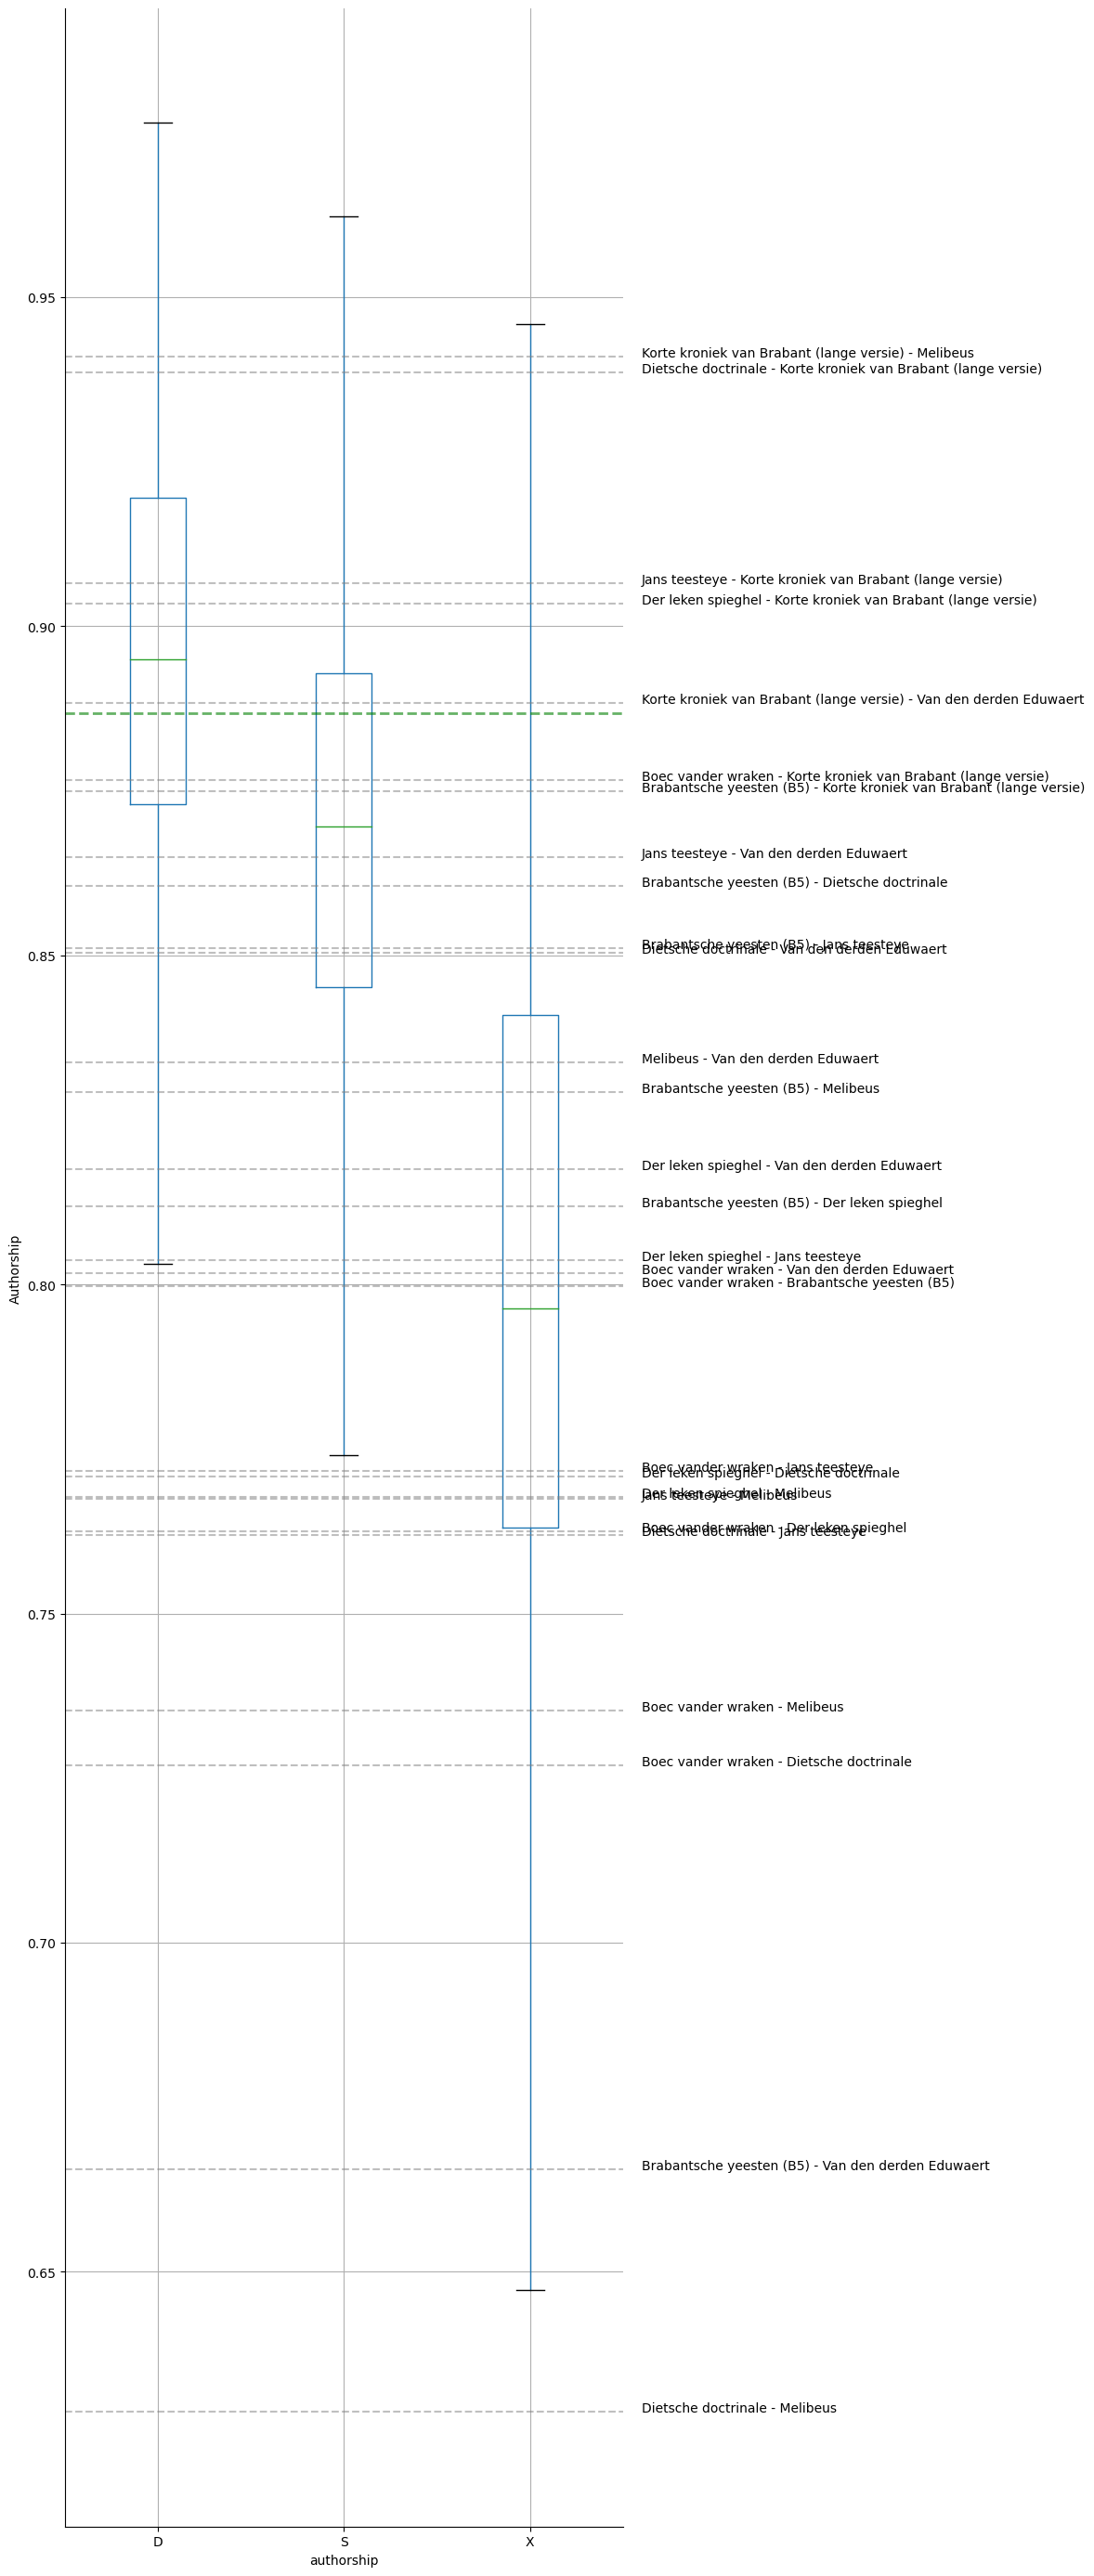

In [18]:
trg_X = vectorizer.transform(trg_df['text']).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 28), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.ylabel('Distance')
plt.ylabel('Authorship')
plt.suptitle('')

plt.tight_layout();

## Networks

In [19]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1989)
segment_df.sample(5)

100%|████████████████████████████████████████| 164/164 [00:00<00:00, 830.09it/s]


title              author  genre  \
13   Boec vander wraken                     Jan van Boendale    Epiek   
263  Spiegel historiael (P1-P4)             Jacob van Maerlant  Epiek   
274  Spiegel historiael (P1-P4)             Jacob van Maerlant  Epiek   
54   Der mannen ende vrouwen heimelijcheit  NaN                 Epiek   
145  Merlijn                                Jacob van Maerlant  Epiek   

           subgenre  segment-idx  \
13   Didactiek       1             
263  Historiografie  30            
274  Historiografie  41            
54   Didactiek       1             
145  Arthur          4             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  
13   [mens, wensen, knecht, slecht, heer, immermeer, fijn, zijn, schrijven, leven, vlieden, zien, trouw, schouwen, zin, in, leren, heer, zeggen, wijsheid, zijn, zijn, beide, ontfermigheid, zekerlijk, aardrijk, klop, oppen, alzo, vroe, wraak, geraken, in, begin, schouwen, nauw, kroniek, gelijke, stond, zonde, willen, zullen, zwaarlijk, zekerlijk, dongelijk, dag, verdragen, ontfermigheid, gerechtigheid, zaan, staan, gerechtigheid, stede, verdrijven, blijven, nijd, benedijen, staan, zaan, leven, hebben, klaar, naar, NOU-P, heer, overmoed, gloed, al, zullen, wreken, breken, alleen, gemeen, dag, beklagen, zin, NOU-P, doen, groot, stonde, mond, vinden, kind, stonde, sonde, gram, nemen, groot, dood, leven, drijven, na, NOU-P, twaar, zijn, stond, zonde, NOU-P, kroon, verdrinken, ...]  
263  [beduiden, lieden, tijd, doorlijden, heer, leer, laten, uitermate, NOU-P, wel, abdie, partij, verhelen, verstelen, gemeen, alleen, brood, boten, uitermate, caritaat, gat, dat, weldaad, kwaad, geschieden, laten, wijze, spijs, gat, mate, klemmen, krom, bekennen, gezenden, recht, knecht, zin, begin, zien, plegen, eindigen, doen, oog, togen, begeven, leven, keren, onteren, zien, lachen, voort, schorten, wil, stillen, naar, zwaar, land, altehand, zijn, naar, gehengen, dwingen, heten, niet, venijn, zijn, vat, dat, zijn, woestijn, wassen, dies, komen, aannemen, mogen, gedachte, mijl, wijl, geboren, toren, doen, beraden, brengen, onzacht, lid, bede, zo, stro, groot, dood, kerk, klerk, diaken, zaak, deur, uur, opvoeden, stoet, graf, af, ...]                                         
274  [heten, zwaar, daar, geliggen, dragen, niet, heten, klein, gemeen, vergeten, weten, raken, maken, jaar, overwaar, zoon, gene, vader, algader, zeggen, liggen, man, gewinnen, NOU-P, wassen, naam, samen, heten, laten, hand, NOU-P, dood, groot, stad, dat, daarnaar, zijn, NOU-P, dan, vangen, zaan, jaar, daar, dat, stad, wreken, stoken, jaar, daar, bezitten, terijten, man, NOU-P, genade, doen, tijd, lijden, komen, nemen, man, aan, zoeken, brengen, misbaren, vaart, NOU-P, de, zaan, gaan, tijd, strijd, NOU-P, man, bevangen, afdoen, NOU-P, nochtan, haar, naar, mede, stede, toe, toen, ile, wijl, martelaar, zijn, jaar, voorwaar, NOU-P, gewinnen, naam, nemen, kruid, luid, heten, zien, dood, groot, wel, ...]                                                                               
54   [heer, immermeer, zullen, smal, ding, gehengen, zijn, ik, stond, vinden, zullen, al, staan, aangaan, worden, horen, tijd, zijn, zoeken, beuk, staden, raden, zaak, maken, deze, lezen, heimelijkheid, mede, openbaar, entaar

In [20]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    
    show(p)
    
    return p

sub_df = segment_df[segment_df['subgenre'].isin({'Didactiek', 'Historiografie'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=20)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

plot = scatterplot(X, sub_df, label_column='title', color_column='title')
plot

figure(id='p1004', ...)

In [21]:
# Also save
#import selenium
from bokeh.io.export import export_svgs
plot.output_backend = "svg"  # Enable SVG output
export_svgs(plot, filename="../figures/scatterplot.svg")

['../figures/scatterplot.svg']

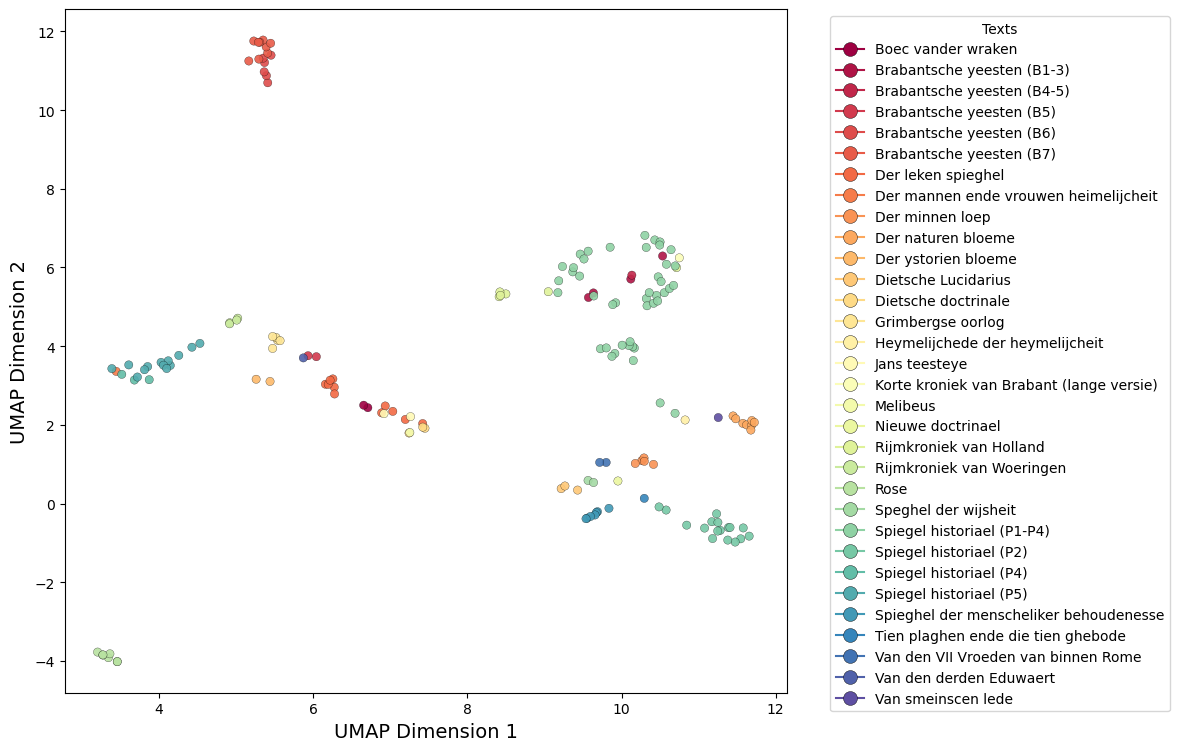

In [22]:
import umap.umap_ as umap

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=20)
X_pca = pca_model.fit_transform(BOW)

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(sub_df['title'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
text_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'{text}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, text in enumerate(text_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Texts", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
#plt.savefig('figures-and-tables/scatterplot_1.svg', dpi=600, bbox_inches='tight')
plt.show()

In [23]:
import plotly.express as px
import pandas as pd

# Map categorical titles to a numeric scale for coloring
sub_df['title_numeric'] = pd.Categorical(sub_df['title']).codes

# Add UMAP coordinates back to the dataframe for ease of access
sub_df['UMAP Dimension 1'] = X_umap[:, 0]
sub_df['UMAP Dimension 2'] = X_umap[:, 1]

# Use a color scale based on the numeric mapping of titles
fig = px.scatter(sub_df, x='UMAP Dimension 1', y='UMAP Dimension 2', 
                 color='title_numeric', hover_data=['title'], 
                 labels={'title': 'title'}, 
                 color_continuous_scale='Spectral')  # You can change 'Viridis' to any other scale

# Add title and axis labels
fig.update_layout(title='UMAP Scatter Plot of Charter Texts by Scribes',
                  xaxis_title='UMAP Dimension 1',
                  yaxis_title='UMAP Dimension 2',
                  width=800,  # Adjust width
                  height=600,  # Adjust height to make it square
                  margin=dict(l=40, r=40, t=40, b=40)  # Adjust margins to avoid clipping
)

# Show interactive plot
fig.show()

In [24]:
# nog met andere vergelijken? sub_df = segment_df[segment_df['title'].isin({''})]
sub_df = trg_df

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

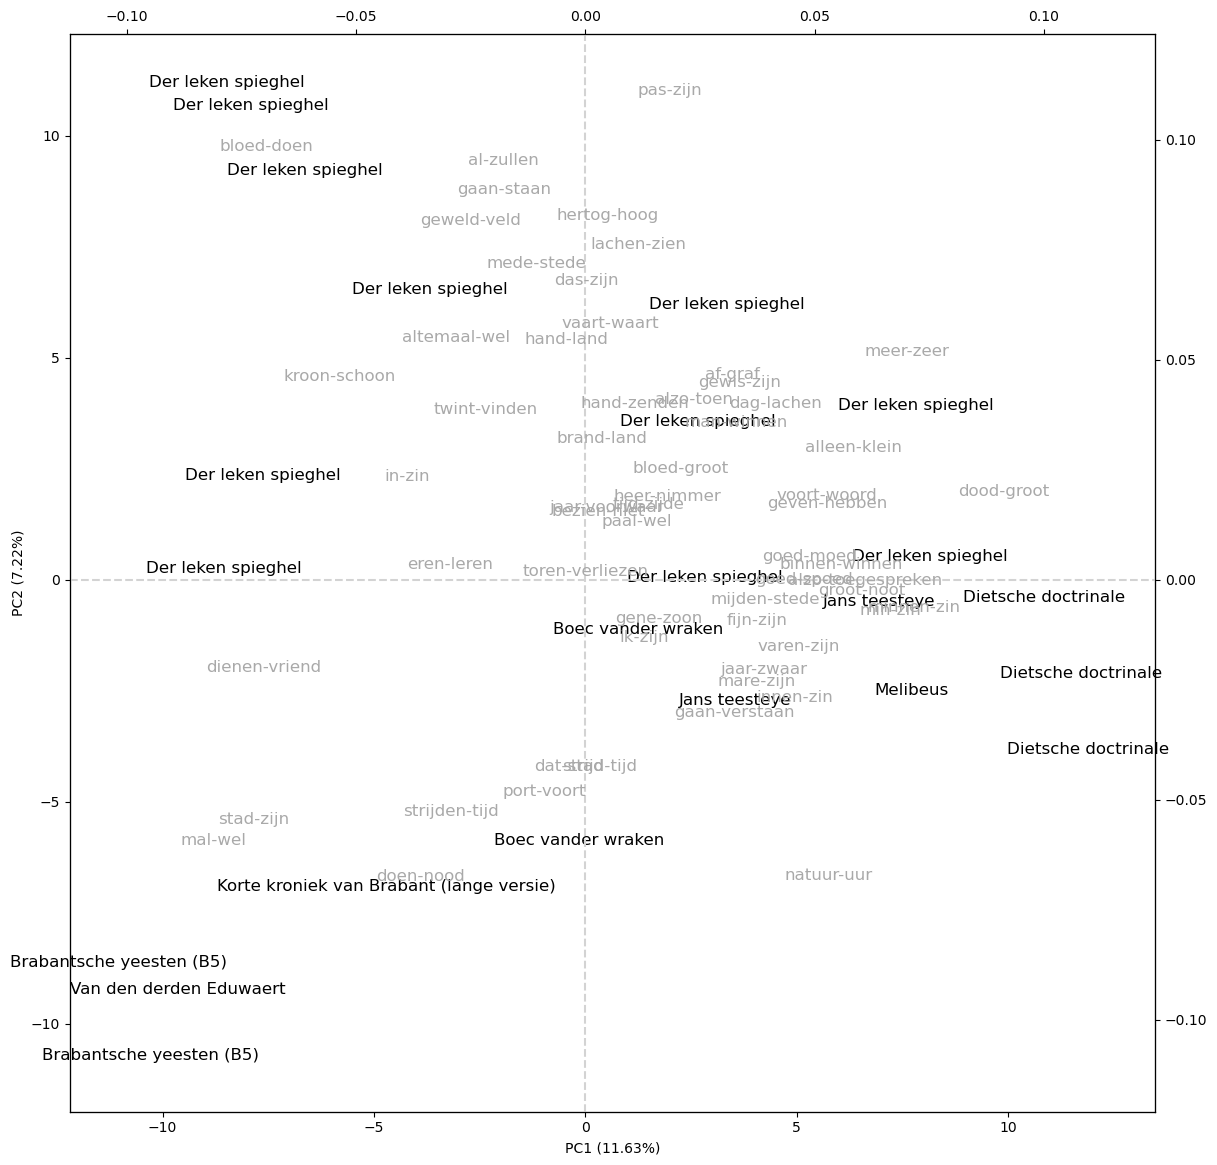

In [25]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

100%|████████████████████████████████████████| 164/164 [00:00<00:00, 441.77it/s]
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/545163806.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/545163806.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



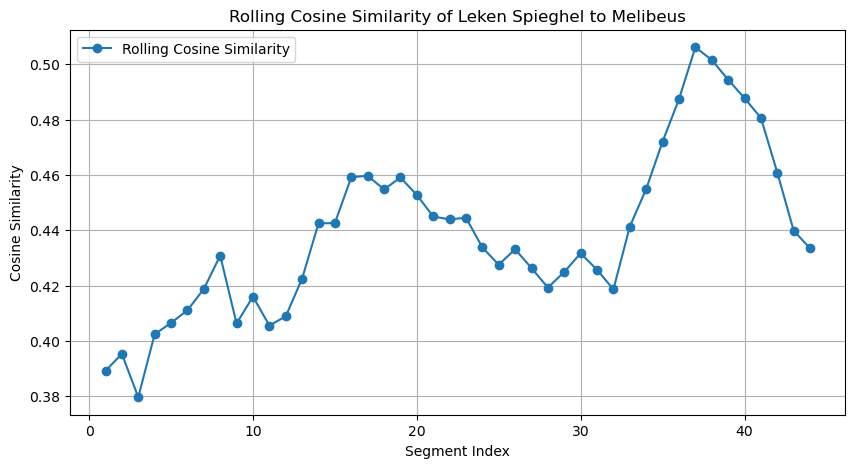

segment-idx  Cosine_Similarity  Rolling_Similarity
193  1            0.389219           0.389219          
194  2            0.401406           0.395312          
195  3            0.348357           0.379661          
196  4            0.470734           0.402429          
197  5            0.422838           0.406511          
198  6            0.412180           0.411103          
199  7            0.439682           0.418758          
200  8            0.408831           0.430853          
201  9            0.347990           0.406304          
202  10           0.471462           0.416029          
203  11           0.359809           0.405555          
204  12           0.456297           0.408878          
205  13           0.477124           0.422537          
206  14           0.447725           0.442483          
207  15           0.471948           0.442581          
208  16           0.442666           0.459152          
209  17           0.458960           0.459685          
210  18           0.452402           0.454740          
211  19           0.469287           0.459053          
212  20           0.440410           0.452745          
213  21           0.403796           0.444971          
214  22           0.453588           0.443897          
215  23           0.455569           0.444530          
216  24           0.415479           0.433769          
217  25           0.409316           0.427550          
218  26           0.431680           0.433127          
219  27           0.419594           0.426328          
220  28           0.420245           0.419263          
221  29           0.443947           0.424956          
222  30           0.442862           0.431666          
223  31           0.401812           0.425692          
224  32           0.384364           0.418646          
225  33           0.533629           0.441323          
226  34           0.511951           0.454924          
227  35           0.528342           0.472020          
228  36           0.478477           0.487353          
229  37           0.478229           0.506125          
230  38           0.510618           0.501523          
231  39           0.476423           0.494418          
232  40           0.494815           0.487712          
233  41           0.442933           0.480604          
234  42           0.379460           0.460850          
235  43           0.405645           0.439855          
236  44           0.444433           0.433457

In [116]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=500)
comp = segment_df[segment_df['title'].isin(['Der leken spieghel', 'Melibeus'])]
comp
mel = comp[comp["title"] == "Melibeus"]
ls = comp[comp["title"] == "Der leken spieghel"]

# Convert the "text" columns to a list of strings
mel_text = mel["text"].astype(str).tolist()  # Convert Melibeus text to list of strings
ls_text = ls["text"].astype(str).tolist()  # Convert Leken Spieghel text to list of strings

# Combine the two texts into a list of strings for fitting
vectorizer = TfidfVectorizer(**params)
vectorizer.fit(mel_text + ls_text)

# Transform Melibeus and Leken Spieghel text using the vectorizer
mel_vec = vectorizer.transform([" ".join(mel_text)])  # Entire Melibeus as one document
ls_vec = vectorizer.transform(ls_text)  # Each segment separately

# Calculate cosine similarity of each LS segment to the entire Mel
similarities = cosine_similarity(ls_vec, mel_vec)

# Add similarity scores to DataFrame
ls["Cosine_Similarity"] = similarities

# Rolling similarity for smoother visualization
ls["Rolling_Similarity"] = ls["Cosine_Similarity"].rolling(window=5, min_periods=1).mean()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(ls["segment-idx"], ls["Rolling_Similarity"], marker='o', linestyle='-', label='Rolling Cosine Similarity')
plt.xlabel("Segment Index")
plt.ylabel("Cosine Similarity")
plt.title("Rolling Cosine Similarity of Leken Spieghel to Melibeus")
plt.legend()
plt.grid(True)
plt.show()

# Display results
ls[["segment-idx", "Cosine_Similarity", "Rolling_Similarity"]]

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1125.12it/s]
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/2975687242.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/2975687242.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



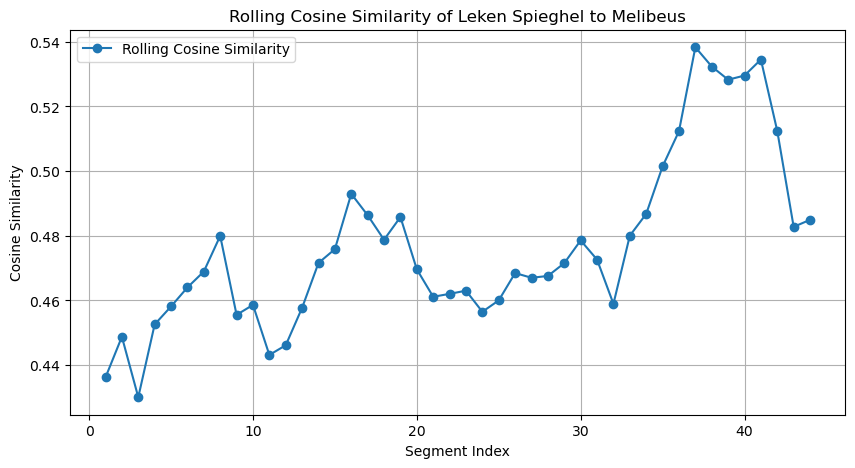

segment-idx  Cosine_Similarity  Rolling_Similarity
193  1            0.436184           0.436184          
194  2            0.461330           0.448757          
195  3            0.392662           0.430058          
196  4            0.520123           0.452575          
197  5            0.480397           0.458139          
198  6            0.465601           0.464022          
199  7            0.485894           0.468935          
200  8            0.447803           0.479964          
201  9            0.397981           0.455535          
202  10           0.495827           0.458621          
203  11           0.388192           0.443140          
204  12           0.500844           0.446130          
205  13           0.505840           0.457737          
206  14           0.467291           0.471599          
207  15           0.517155           0.475864          
208  16           0.473762           0.492978          
209  17           0.467718           0.486353          
210  18           0.467947           0.478775          
211  19           0.502399           0.485796          
212  20           0.436294           0.469624          
213  21           0.431296           0.461131          
214  22           0.472238           0.462035          
215  23           0.472844           0.463014          
216  24           0.469783           0.456491          
217  25           0.453902           0.460013          
218  26           0.473573           0.468468          
219  27           0.464960           0.467012          
220  28           0.475625           0.467569          
221  29           0.489631           0.471538          
222  30           0.489042           0.478566          
223  31           0.443915           0.472635          
224  32           0.396499           0.458943          
225  33           0.581039           0.480025          
226  34           0.523376           0.486774          
227  35           0.562496           0.501465          
228  36           0.498312           0.512344          
229  37           0.526429           0.538330          
230  38           0.551204           0.532363          
231  39           0.502974           0.528283          
232  40           0.568923           0.529568          
233  41           0.523103           0.534526          
234  42           0.415794           0.512399          
235  43           0.403031           0.482765          
236  44           0.513825           0.484935

In [121]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=500)
comp = segment_df[segment_df['title'].isin(['Der leken spieghel', 'Dietsche doctrinale'])]
comp
mel = comp[comp["title"] == "Dietsche doctrinale"]
ls = comp[comp["title"] == "Der leken spieghel"]

# Convert the "text" columns to a list of strings
mel_text = mel["text"].astype(str).tolist()  # Convert Melibeus text to list of strings
ls_text = ls["text"].astype(str).tolist()  # Convert Leken Spieghel text to list of strings

# Combine the two texts into a list of strings for fitting
vectorizer = TfidfVectorizer(**params)
vectorizer.fit(mel_text + ls_text)

# Transform Melibeus and Leken Spieghel text using the vectorizer
mel_vec = vectorizer.transform([" ".join(mel_text)])  # Entire Melibeus as one document
ls_vec = vectorizer.transform(ls_text)  # Each segment separately

# Calculate cosine similarity of each LS segment to the entire Mel
similarities = cosine_similarity(ls_vec, mel_vec)

# Add similarity scores to DataFrame
ls["Cosine_Similarity"] = similarities

# Rolling similarity for smoother visualization
ls["Rolling_Similarity"] = ls["Cosine_Similarity"].rolling(window=5, min_periods=1).mean()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(ls["segment-idx"], ls["Rolling_Similarity"], marker='o', linestyle='-', label='Rolling Cosine Similarity')
plt.xlabel("Segment Index")
plt.ylabel("Cosine Similarity")
plt.title("Rolling Cosine Similarity of Leken Spieghel to Melibeus")
plt.legend()
plt.grid(True)
plt.show()

# Display results
ls[["segment-idx", "Cosine_Similarity", "Rolling_Similarity"]]

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1109.89it/s]
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/1576660110.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/1576660110.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



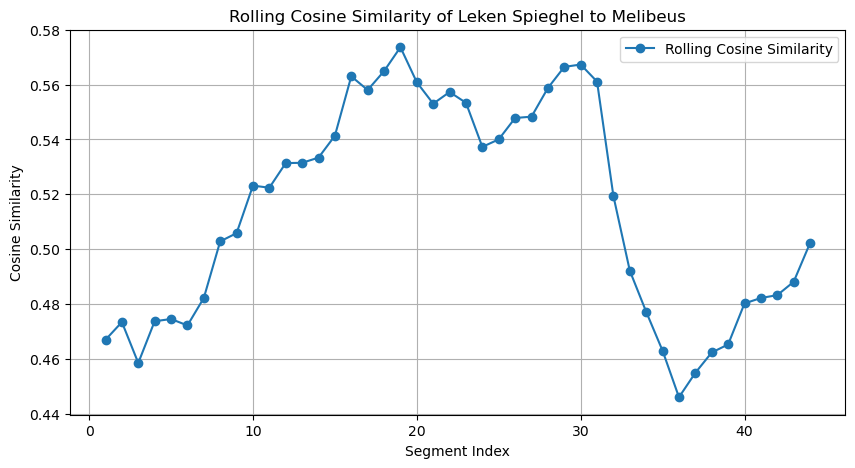

segment-idx  Cosine_Similarity  Rolling_Similarity
193  1            0.467010           0.467010          
194  2            0.479911           0.473461          
195  3            0.428754           0.458559          
196  4            0.519363           0.473760          
197  5            0.477871           0.474582          
198  6            0.455278           0.472236          
199  7            0.529968           0.482247          
200  8            0.531891           0.502874          
201  9            0.534307           0.505863          
202  10           0.564533           0.523196          
203  11           0.451413           0.522423          
204  12           0.574903           0.531410          
205  13           0.532353           0.531502          
206  14           0.543729           0.533386          
207  15           0.604458           0.541371          
208  16           0.559637           0.563016          
209  17           0.549970           0.558029          
210  18           0.566754           0.564910          
211  19           0.587317           0.573627          
212  20           0.540590           0.560854          
213  21           0.520609           0.553048          
214  22           0.571251           0.557304          
215  23           0.547104           0.553374          
216  24           0.506951           0.537301          
217  25           0.554325           0.540048          
218  26           0.559555           0.547837          
219  27           0.573671           0.548321          
220  28           0.599305           0.558761          
221  29           0.545416           0.566454          
222  30           0.558673           0.567324          
223  31           0.528455           0.561104          
224  32           0.364980           0.519366          
225  33           0.463340           0.492173          
226  34           0.470506           0.477191          
227  35           0.487782           0.463013          
228  36           0.443776           0.446077          
229  37           0.409492           0.454979          
230  38           0.500325           0.462376          
231  39           0.485151           0.465305          
232  40           0.562555           0.480260          
233  41           0.453654           0.482236          
234  42           0.414718           0.483281          
235  43           0.524599           0.488136          
236  44           0.555731           0.502252

In [123]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=500)
comp = segment_df[segment_df['title'].isin(['Der leken spieghel', 'Boec vander wraken'])]
comp
mel = comp[comp["title"] == "Boec vander wraken"]
ls = comp[comp["title"] == "Der leken spieghel"]

# Convert the "text" columns to a list of strings
mel_text = mel["text"].astype(str).tolist()  # Convert Melibeus text to list of strings
ls_text = ls["text"].astype(str).tolist()  # Convert Leken Spieghel text to list of strings

# Combine the two texts into a list of strings for fitting
vectorizer = TfidfVectorizer(**params)
vectorizer.fit(mel_text + ls_text)

# Transform Melibeus and Leken Spieghel text using the vectorizer
mel_vec = vectorizer.transform([" ".join(mel_text)])  # Entire Melibeus as one document
ls_vec = vectorizer.transform(ls_text)  # Each segment separately

# Calculate cosine similarity of each LS segment to the entire Mel
similarities = cosine_similarity(ls_vec, mel_vec)

# Add similarity scores to DataFrame
ls["Cosine_Similarity"] = similarities

# Rolling similarity for smoother visualization
ls["Rolling_Similarity"] = ls["Cosine_Similarity"].rolling(window=5, min_periods=1).mean()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(ls["segment-idx"], ls["Rolling_Similarity"], marker='o', linestyle='-', label='Rolling Cosine Similarity')
plt.xlabel("Segment Index")
plt.ylabel("Cosine Similarity")
plt.title("Rolling Cosine Similarity of Leken Spieghel to Melibeus")
plt.legend()
plt.grid(True)
plt.show()

# Display results
ls[["segment-idx", "Cosine_Similarity", "Rolling_Similarity"]]

100%|███████████████████████████████████████| 164/164 [00:00<00:00, 1132.36it/s]
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/4121110293.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_58102/4121110293.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



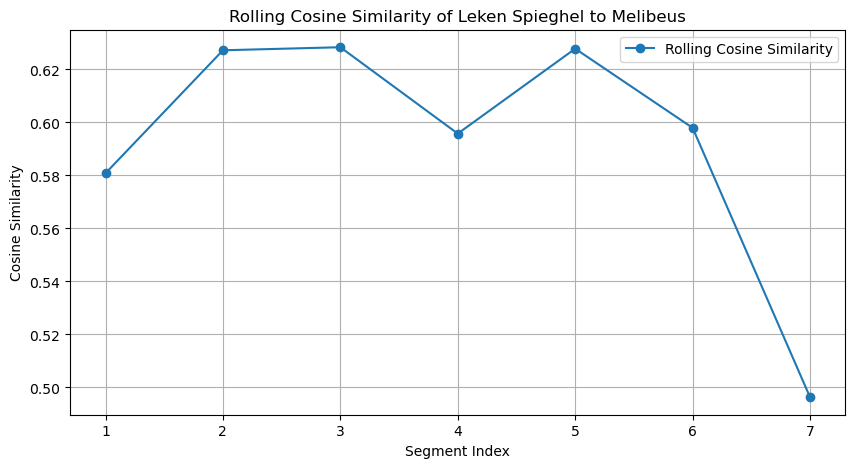

segment-idx  Cosine_Similarity  Rolling_Similarity
628  1            0.580843           0.580843          
629  2            0.627248           0.627248          
630  3            0.628404           0.628404          
631  4            0.595801           0.595801          
632  5            0.627852           0.627852          
633  6            0.597974           0.597974          
634  7            0.496324           0.496324

In [126]:
segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=500)
comp = segment_df[segment_df['title'].isin(['Dietsche doctrinale', 'Melibeus'])]
comp
mel = comp[comp["title"] == "Dietsche doctrinale"]
ls = comp[comp["title"] == "Melibeus"]

# Convert the "text" columns to a list of strings
mel_text = mel["text"].astype(str).tolist()  # Convert Melibeus text to list of strings
ls_text = ls["text"].astype(str).tolist()  # Convert Leken Spieghel text to list of strings

# Combine the two texts into a list of strings for fitting
vectorizer = TfidfVectorizer(**params)
vectorizer.fit(mel_text + ls_text)

# Transform Melibeus and Leken Spieghel text using the vectorizer
mel_vec = vectorizer.transform([" ".join(mel_text)])  # Entire Melibeus as one document
ls_vec = vectorizer.transform(ls_text)  # Each segment separately

# Calculate cosine similarity of each LS segment to the entire Mel
similarities = cosine_similarity(ls_vec, mel_vec)

# Add similarity scores to DataFrame
ls["Cosine_Similarity"] = similarities

# Rolling similarity for smoother visualization
ls["Rolling_Similarity"] = ls["Cosine_Similarity"].rolling(window=1, min_periods=1).mean()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(ls["segment-idx"], ls["Rolling_Similarity"], marker='o', linestyle='-', label='Rolling Cosine Similarity')
plt.xlabel("Segment Index")
plt.ylabel("Cosine Similarity")
plt.title("Rolling Cosine Similarity of Leken Spieghel to Melibeus")
plt.legend()
plt.grid(True)
plt.show()

# Display results
ls[["segment-idx", "Cosine_Similarity", "Rolling_Similarity"]]

## Verification

In [26]:
params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(335, 10000)

In [27]:
num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = [#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                 'Korte kroniek van Brabant (lange versie)',
                 'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'
                ]

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Brabantsche yeesten (B5): 100%|███████████████████| 2/2 [00:01<00:00,  1.99it/s]
Korte kroniek van Brabant (korte versie 1): 0it [00:00, ?it/s]
Melibeus: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
Boec Exemplaer: 0it [00:00, ?it/s]
Boec vander wraken: 100%|█████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


Target  \
0  Korte kroniek van Brabant (lange versie)     
1  Brabantsche yeesten (B5)                     
2  Korte kroniek van Brabant (korte versie 1)   
3  Der leken spieghel                           
4  Jans teesteye                                
5  Van den derden Eduwaert                      
6  Melibeus                                     
7  Boec Exemplaer                               
8  Dietsche doctrinale                          
9  Boec vander wraken                           

                                Rank 1                               Rank 2  \
0  Brabantsche yeesten (B1-3) (49.60%)  Rijmkroniek van Holland (17.20%)      
1  Van den derden Eduwaert (78.20%)     Brabantsche yeesten (B4-5) (10.60%)   
2  None                                 None                                  
3  Boec vander wraken (33.16%)          Dietsche doctrinale (22.95%)          
4  Dietsche doctrinale (48.80%)         Boec vander wraken (26.00%)           
5  Brabantsche yeesten (B5) (85.60%)    Brabantsche yeesten (B4-5) (9.60%)    
6  Dietsche doctrinale (99.20%)         Der leken spieghel (0.80%)            
7  None                                 None                                  
8  Melibeus (96.53%)                    Der leken spieghel (2.93%)            
9  Dietsche doctrinale (43.20%)         Melibeus (40.80%)                     

                                Rank 3                               Rank 4  \
0  Brabantsche yeesten (B4-5) (16.80%)  Spiegel historiael (P1-P4) (11.60%)   
1  Brabantsche yeesten (B1-3) (5.20%)   Grimbergse oorlog (3.20%)             
2  None                                 None                                  
3  Melibeus (14.11%)                    Jans teesteye (8.40%)                 
4  Melibeus (15.60%)                    Der leken spieghel (9.60%)            
5  Brabantsche yeesten (B1-3) (1.60%)   Der leken spieghel (0.80%)            
6  None                                 None                                  
7  None                                 None                                  
8  Boec vander wraken (0.53%)           None                                  
9  Der leken spieghel (7.20%)           Jans teesteye (7.00%)                 

                               Rank 5  
0  Rijmbijbel (2.40%)                  
1  Roman der Lorreinen II (1.40%)      
2  None                                
3  Brabantsche yeesten (B5) (7.05%)    
4  None                                
5  Der ystorien bloeme (0.80%)         
6  None                                
7  None                                
8  None                                
9  Brabantsche yeesten (B4-5) (1.00%)

## Feature analysis

### "Oeuvre"

In [150]:
BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                 'Brabantsche yeesten (B5)',
                                 'Korte kroniek van Brabant (korte versie 1)',
                                 'Korte kroniek van Brabant (lange versie)',
                                 'Der leken spieghel', 'Jans teesteye', 
                                 'Van den derden Eduwaert', 'Melibeus', 'Boec Exemplaer', 
                                 'Dietsche doctrinale', 'Boec vander wraken'])

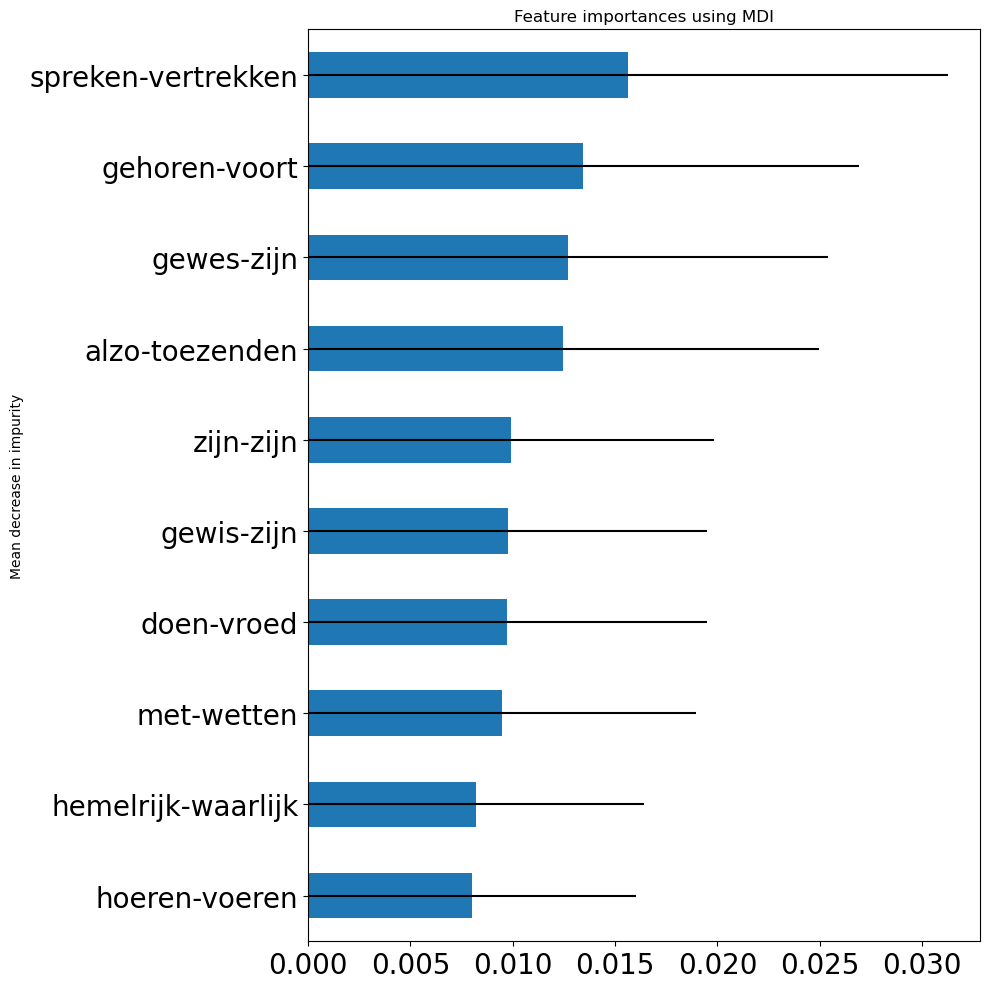

In [151]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



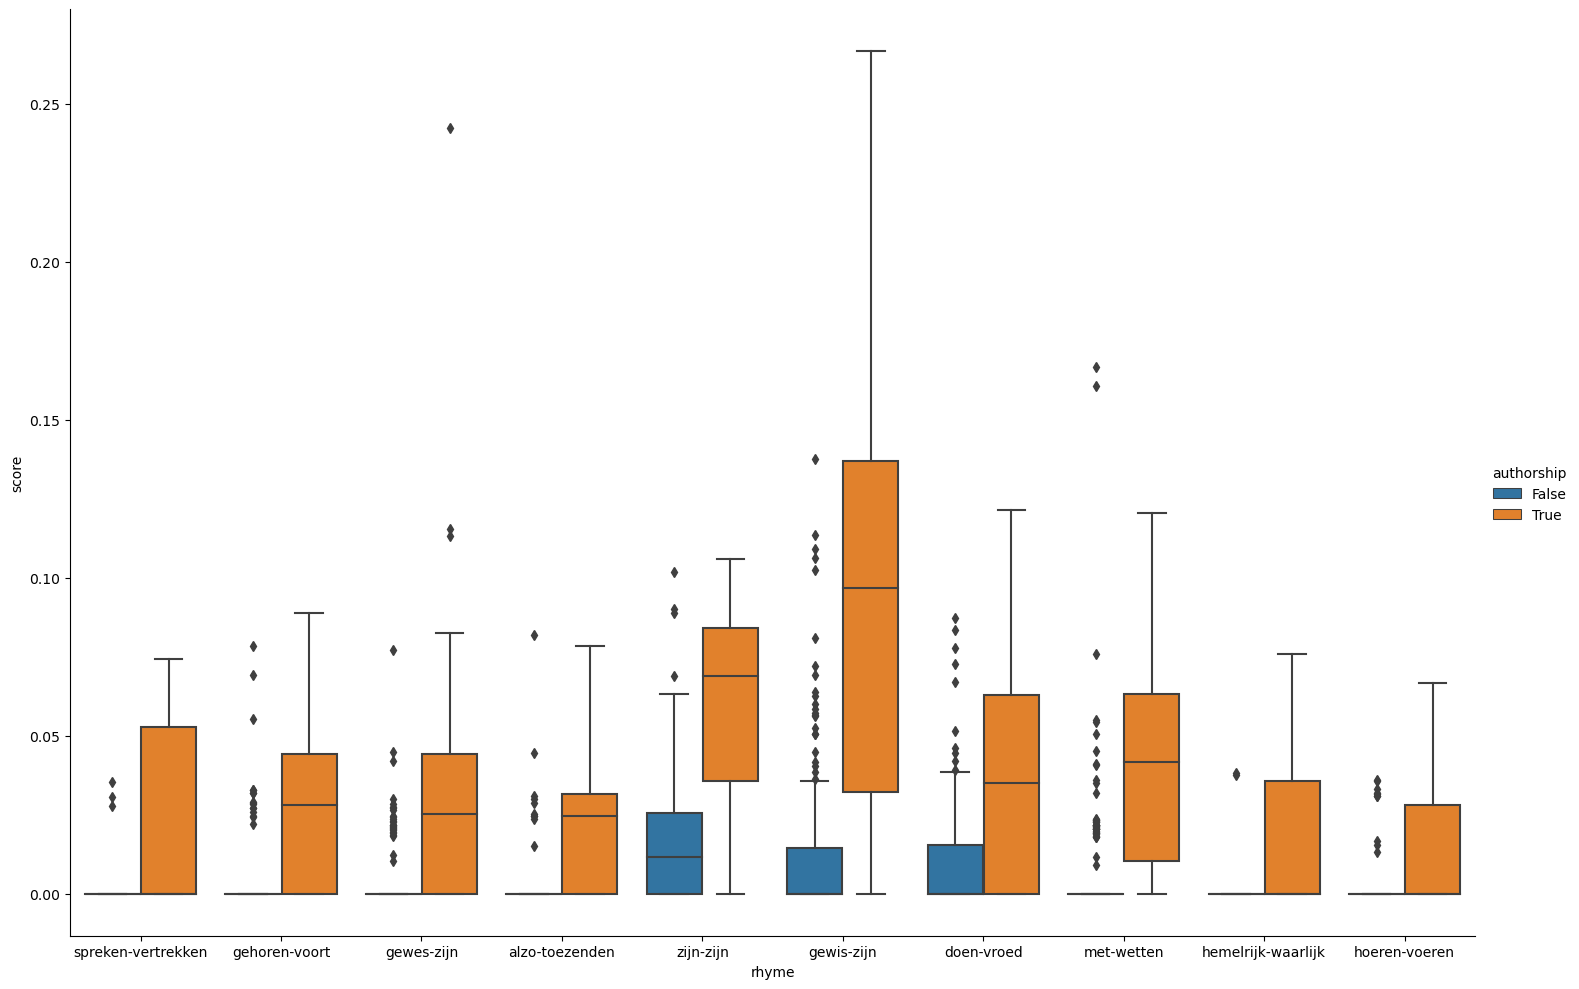

In [152]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);

## Jans teesteye

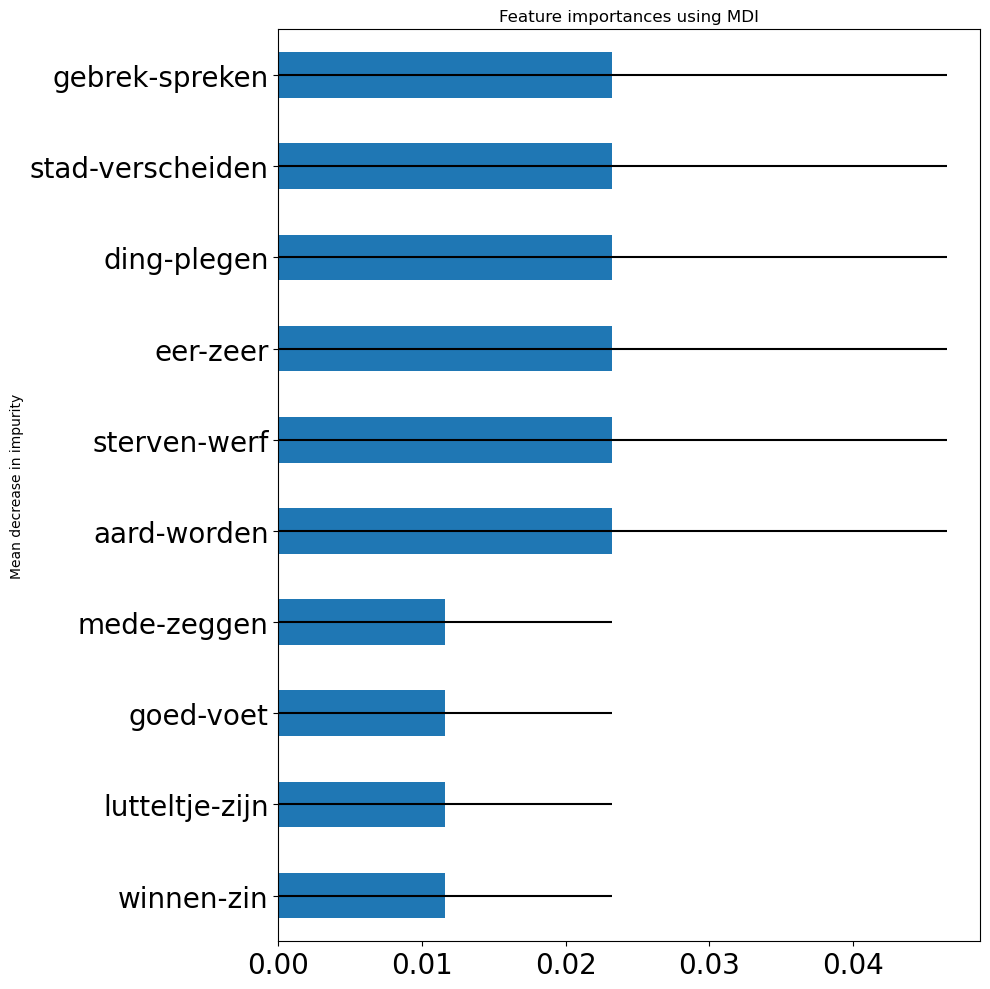

In [155]:
epics = epics[epics['title'].isin([#'Brabantsche yeesten (B1-3)', 'Brabantsche yeesten (B4-5)',
                                   'Brabantsche yeesten (B5)', 'Korte kroniek van Brabant (korte versie 1)',
                 'Der leken spieghel', 'Jans teesteye', 'Van den derden Eduwaert', 
                 'Melibeus', 'Boec Exemplaer', 'Dietsche doctrinale', 'Boec vander wraken'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Jans teesteye'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



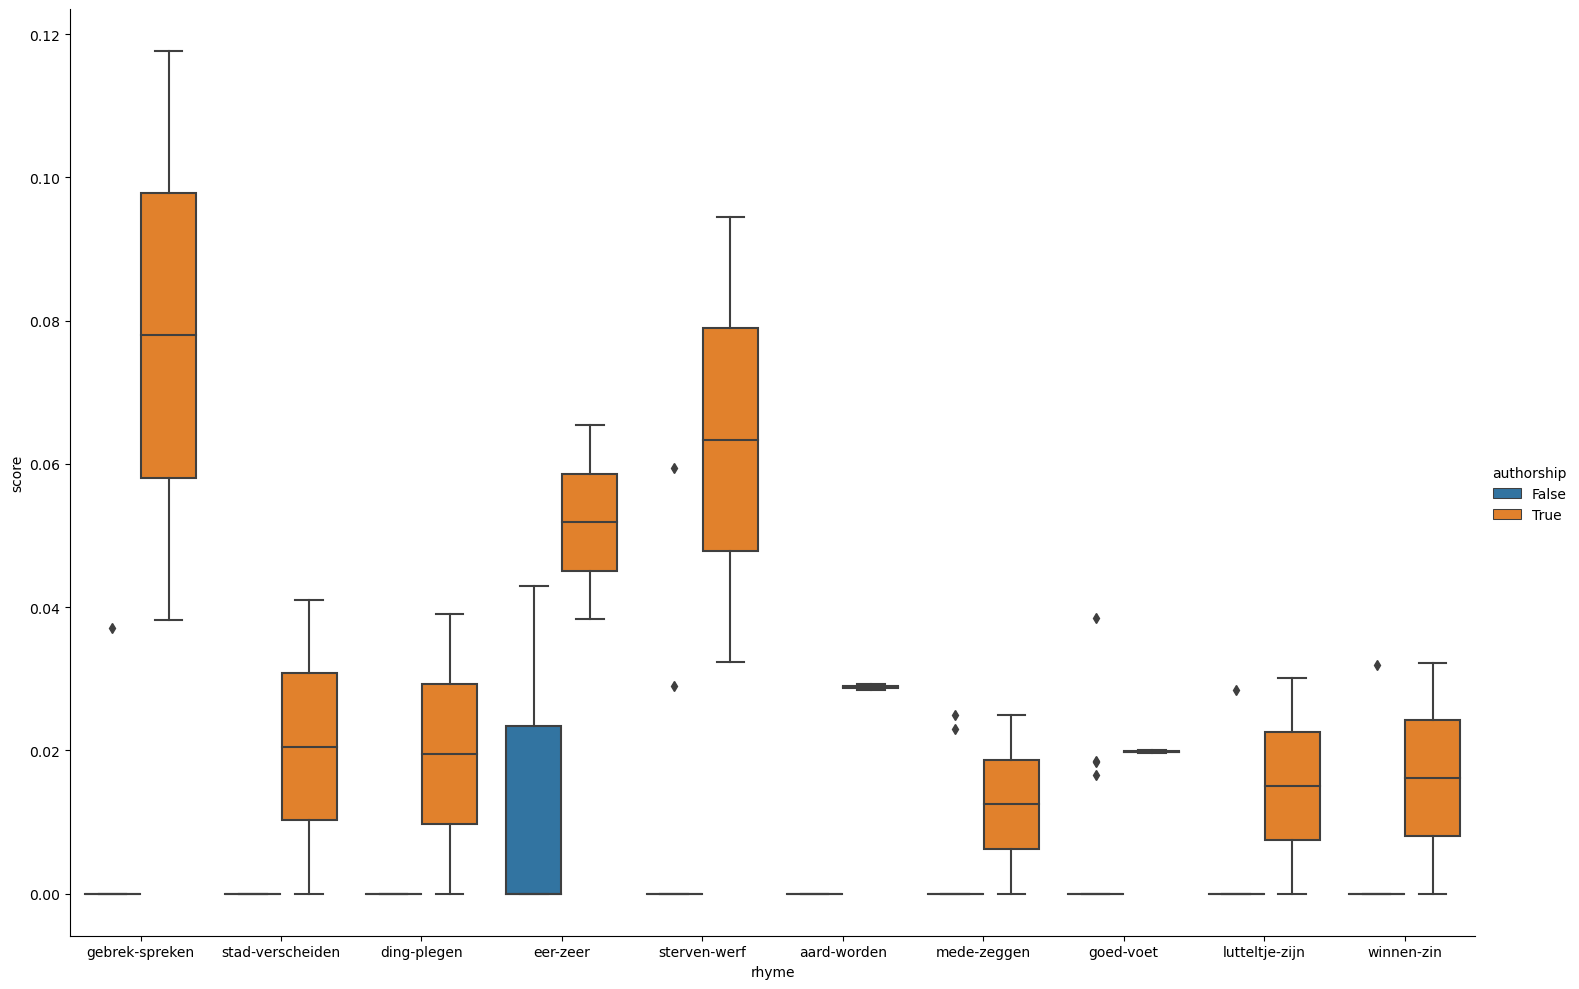

In [156]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='rhyme', value_name='score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
sb.catplot(x="rhyme", hue="authorship", y="score", data=bow, kind='box', height=10, aspect=1.5);